In [1]:
import pyspark.sql.functions as sf
from pyspark.sql.types import *
from pyspark.ml.feature import StopWordsRemover
import matplotlib.pyplot as plt
# from pyspark.sql.functions import explode, sum


In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("spark://127.0.0.1:7077")
    # the number of executors this job needs
    .config("spark.executor.instances", 2)
    # the number of CPU cores memory this needs from the executor,
    # it would be reserved on the worker
    .config("spark.executor.cores", "2")
    .config("spark.executor.memory", "4G")
    .getOrCreate()
)
sc = spark.sparkContext

23/11/28 22:40:05 WARN Utils: Your hostname, Dianas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.39 instead (on interface en0)
23/11/28 22:40:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 22:40:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Pet Supplies Product Data

In [3]:
data_df = spark.read.json("data/Pet_Supplies.json")

In [5]:
# data_schema = StructType([StructField("asin", StringType(), True),
#                             # StructField("image", StringType(), True),
#                             StructField("overall", DoubleType(), True),
#                             StructField("reviewText", StringType(), True),
#                             StructField("reviewTime", StringType(), True),
#                             StructField("reviewerID", StringType(), True),
#                             StructField("reviewerName", StringType(), True),
#                             StructField("style", StructType([
#                                 StructField("Color Name", StringType(), True),
#                                 StructField("Color", StringType(), True),
#                                 StructField("Design", StringType(), True),
#                                 StructField("Flavor Name", StringType(), True),
#                                 StructField("Flavor", StringType(), True),
#                                 StructField("Format", StringType(), True),
#                                 StructField("Item Display Length", StringType(), True),
#                                 StructField("Item Display Weight", StringType(), True),
#                                 StructField("Item Package Quantity", StringType(), True),
#                                 StructField("Item Shape", StringType(), True),
#                                 StructField("Length", StringType(), True),
#                                 StructField("Material", StringType(), True),
#                                 StructField("Model Number", StringType(), True),
#                                 StructField("Number of Items", StringType(), True),
#                                 StructField("Package Quantity", StringType(), True),
#                                 StructField("Package Type", StringType(), True),
#                                 StructField("Pattern", StringType(), True),
#                                 StructField("Product Packaging", StringType(), True),
#                                 StructField("Scent Name", StringType(), True),
#                                 StructField("Scent", StringType(), True),
#                                 StructField("Size Name", StringType(), True),
#                                 StructField("Size", StringType(), True),
#                                 StructField("Style Name", StringType(), True),
#                                 StructField("Style", StringType(), True),
#                                 StructField("Wattage", StringType(), True)]), True),
#                             StructField("summary", StringType(), True),
#                             StructField("unixReviewTime", LongType(), True),
#                             StructField("verified", BooleanType(), True),
#                             StructField("vote", StringType(), True)])


In [4]:
# output count of reviewerID and count unique reviewerID
print(data_df.select("reviewerID").count()) 
print(data_df.select("reviewerID").distinct().count())

6542483


3085591


Add primary key to dataset

In [5]:
# add a distinct key to each row of data_df
add_keys = data_df.withColumn("id", sf.monotonically_increasing_id())

#check count distinct id
# print(f"Distinct keys: {add_keys.select("id").distinct().count()}")

## Process Review Text
Preprocessing: remove null values

In [6]:
review_df = add_keys.select('id', 'overall', 'reviewText')

# check null values
print(f"Null reviewText: {review_df.filter(sf.col('reviewText').isNull()).count()}")
print(f"Null overall: {review_df.filter(sf.col('overall').isNull()).count()}")

# drop null reviewText values
review_df = review_df.filter(sf.col('reviewText').isNotNull())

# check for null values in review_df
print(f"Check null reviewText removed: {review_df.filter(sf.col('reviewText').isNull()).count()}")

Null reviewText: 3796


Null overall: 0


Check null reviewText removed: 0


In [7]:
# calculate statistics of overall
print("Statistics of overall rating: ")
review_df.select('overall').describe().show()

Statistics of overall rating: 


+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|           6538687|
|   mean|  4.14919600831176|
| stddev|1.3433625313841773|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



Down sample dataset with matchng distribution for development

In [8]:
distribution = review_df.groupBy('overall').count().collect()

# Calculate the sampling ratios based on the distribution
sampling_ratios = {row['overall']: 0.1 for row in distribution}

# Use sampleBy to downsample the data
review_df = review_df.sampleBy('overall', fractions=sampling_ratios, seed=42)

# Show the downsampled DataFrame
review_df.show()

+---+-------+--------------------+
| id|overall|          reviewText|
+---+-------+--------------------+
|  7|    3.0|Maybe it's just m...|
| 16|    1.0|Horrible just a w...|
| 18|    5.0|           its great|
| 50|    1.0|seriously, buy a ...|
| 58|    5.0|This is the best ...|
| 63|    1.0|When I bought thi...|
| 66|    3.0|They came to me r...|
| 72|    5.0|It doesn't make s...|
| 79|    2.0|Purchased this ca...|
| 88|    4.0|Two of three of t...|
| 90|    5.0|My cat loves the ...|
|103|    5.0|powerful protecti...|
|105|    5.0|Power - Mune Chic...|
|106|    5.0|power mune by vet...|
|109|    5.0|Liver Support" Su...|
|123|    5.0|Excellent-so info...|
|129|    1.0|Bad science. Bad ...|
|139|    5.0|I Love Love Love ...|
|142|    5.0|            Awesome!|
|176|    5.0|Fast shipping.. L...|
+---+-------+--------------------+
only showing top 20 rows



## Analysis of Review Text

### Visualuze count distribution of overall rating

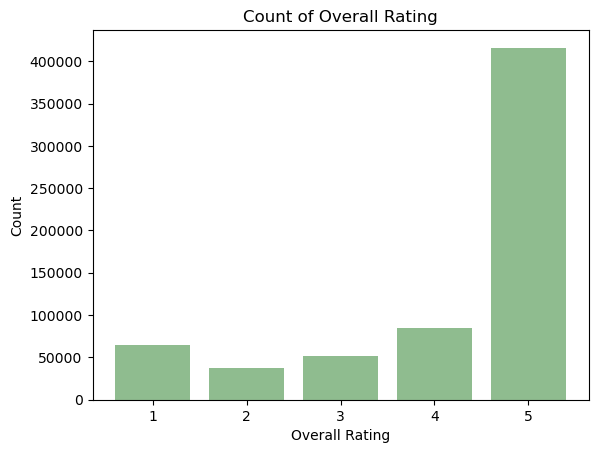

In [ ]:
# convert columns id and overall from sampled_df to pd
sampled_df_pd = review_df.select('overall').toPandas()
# convert overall col to int
sampled_df_pd['overall'] = sampled_df_pd['overall'].astype(int)

plt.bar(sampled_df_pd['overall'].value_counts().index, 
        sampled_df_pd['overall'].value_counts().values,
        color='darkseagreen')
plt.title('Count of Overall Rating')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

#### Process and clean reviewText

In [9]:
# remove punctuation from reviewText, convert to lowercase, split reviews into list of words
clean_txt = review_df.withColumn("reviewText", sf.regexp_replace(sf.col("reviewText"), "[^a-zA-Z0-9\\s]", "")) \
                        .withColumn("reviewText", sf.lower(sf.col("reviewText"))) \
                        .withColumn("splitText", sf.split(sf.col("reviewText"), " "))

# remove stop words [the, with, etc.]
stop_words_remover = StopWordsRemover() \
                    .setInputCol("splitText") \
                    .setOutputCol("filteredWords") \
                    .transform(clean_txt)

# apply stop_words_remover to reviewText column
filtered_df = stop_words_remover.select('id', 'overall', 'reviewText', 'filteredWords')
# print(filtered_df.show(5, truncate=False))

In [ ]:
print(filtered_df.show(5, truncate=False))

+---+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Count word frequency and ad to dictionary of {word: count} using rdd's

In [10]:
# Convert DataFrame to RDD and perform mapping and reduceByKey to create dict of {word : count}
word_counts_rdd = (
    filtered_df.select("id", "filteredWords")
    .rdd  # Convert to RDD for map-reduce
    .flatMap(lambda row: [(word, 1) for word in row["filteredWords"]])
    .reduceByKey(lambda a, b: a + b)
)

# sorted word_counts_rdd by count
word_counts_rdd = word_counts_rdd.sortBy(lambda x: x[1], ascending=False)

In [11]:
# convert word_counts_rdd to dict
word_counts_dict = dict(word_counts_rdd.collect())

# remove all keys '' from word_counts_dict
word_counts_dict = {k: v for k, v in word_counts_dict.items() if k != ''}

top_20_words = dict(sorted(word_counts_dict.items(), key=lambda x: x[1], reverse=True)[:20])

In [14]:
print(top_20_words)

{'dog': 208024, 'great': 142447, 'one': 134607, 'like': 109392, 'product': 109331, 'dogs': 106785, 'love': 106511, 'cat': 101743, 'good': 86109, 'well': 85816, 'get': 82590, 'cats': 75187, 'use': 74654, 'food': 74617, 'loves': 72183, 'little': 62142, 'really': 61773, 'time': 61705, 'much': 58545, 'works': 57229}


In [17]:
def count_words(words):
    """
    Count the number of times each word appears in a list of words.
    Args:
        words (list): list of words
    Returns:
        dict: {word : counts}
    """
    # remove newline characters
    words = [word.replace('\n', '') for word in words]
    # Filter out empty strings
    words = [word for word in words if word.strip()]
    return {word: words.count(word) for word in set(words)}


# add a new column with word counts as a dict
def add_word_counts(row):
    word_counts = count_words(row["filteredWords"])
    return (row["id"], row["overall"], word_counts)

# apply function to each row in the original df
filtered_df_with_counts_rdd = filtered_df.rdd.map(lambda row: add_word_counts(row))
# print(filtered_df_with_counts_rdd.take(5))
# # convert RDD back to df
filtered_df_with_counts = filtered_df_with_counts_rdd.toDF(["id", "overall", "word_counts"])

# filtered_df_with_counts.show(truncate=False)

#### Calculate average rating per review with each of the top 20 most common words

In [27]:
# Explode the word_counts column to separate rows
df_exploded = filtered_df_with_counts.select("id", "overall", sf.explode("word_counts").alias("word", "count"))
# print(df_exploded.show(5, truncate=False))

# Filter rows based on the list of words
top_20_list = list(top_20_words.keys())
df_filtered = df_exploded.filter(df_exploded.word.isin(top_20_list))

# Calculate the sum of ratings and count of occurrences for each word
df_avg_rating = df_filtered.groupBy("word").agg(sf.sum('overall'), sf.sum("count"))

# sort df_avg_rating by count
df_avg_rating = df_avg_rating.sort("sum(count)", ascending=False)
# print(df_avg_rating.show(5, truncate=False))

# Calculate the average rating for each word
df_avg_rating = df_avg_rating.withColumn("avg_rating", df_avg_rating["sum(overall)"] / df_avg_rating["sum(count)"])

# Show the result
df_avg_rating.show(20, truncate=False)

+-------+------------+----------+------------------+
|word   |sum(overall)|sum(count)|avg_rating        |
+-------+------------+----------+------------------+
|dog    |604927.0    |208072    |2.907296512745588 |
|great  |582581.0    |142488    |4.088632025152996 |
|one    |391380.0    |134645    |2.9067547996583607|
|like   |360147.0    |109414    |3.2915988813131776|
|product|361202.0    |109368    |3.3026296540121427|
|dogs   |348912.0    |106827    |3.2661405824370244|
|love   |448787.0    |106525    |4.212973480403661 |
|cat    |278080.0    |101768    |2.7324895841521895|
|good   |326468.0    |86151     |3.789485902659284 |
|well   |327157.0    |85857     |3.8104872054695598|
|get    |273001.0    |82593     |3.3053769689925296|
|cats   |224985.0    |75211     |2.991384239007592 |
|use    |256996.0    |74694     |3.4406511901893055|
|food   |188765.0    |74644     |2.528870371362735 |
|loves  |319070.0    |72186     |4.420109162441471 |
|little |226753.0    |62145     |3.64877303081

#### Plot results of top 20 words along with average rating per word

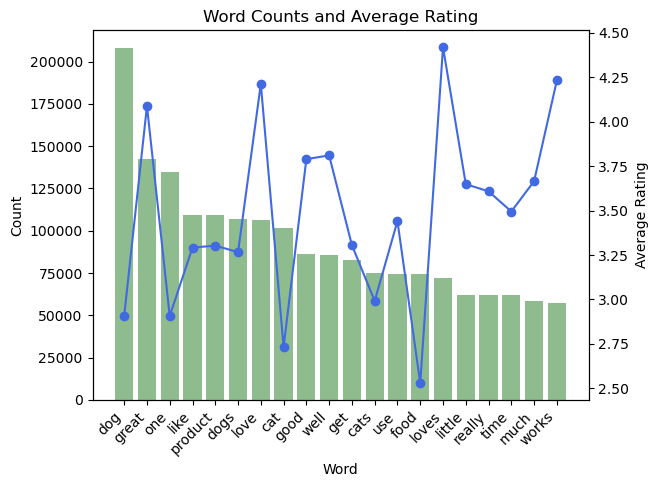

In [ ]:
# plot histogram of word
df_plot = df_avg_rating.toPandas()
fig, ax1 = plt.subplots()

# axis 1 -> bar plot of word counts
ax1.bar(df_plot['word'], 
        df_plot['sum(count)'], 
        color='darkseagreen')
ax1.set_xlabel('Word')
ax1.set_ylabel('Count')

# ax2 -> line plot of average rating
ax2 = ax1.twinx()
ax2.plot(df_plot['word'], 
         df_plot['avg_rating'], 
         color='royalblue', 
         marker='o', 
         label='Average Rating')
ax2.set_ylabel('Average Rating')

# Title for the plot
plt.title('Word Counts and Average Rating')

ticks = range(len(df_plot['word']))
ax1.set_xticks(ticks)
ax2.set_xticks(ticks)
ax1.set_xticklabels(df_plot['word'], rotation=45, ha='right')
ax2.set_xticklabels(df_plot['word'], rotation=45, ha='right')
plt.show()


### Plot most common words for each overall rating group

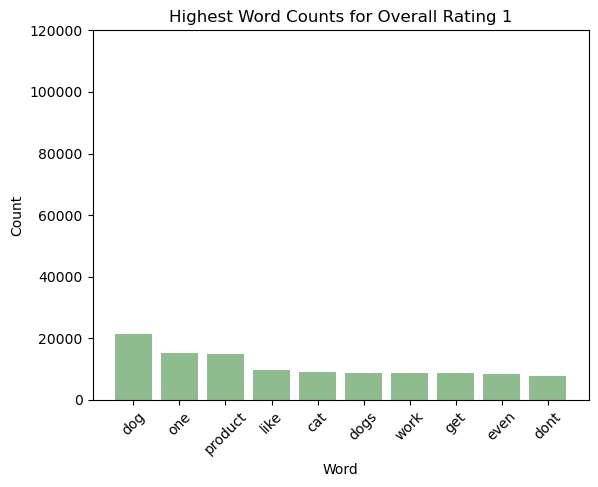

In [ ]:
# df_exploded = filtered_df_with_counts.select("id", "overall", explode("word_counts").alias("word", "count"))
overall_1 = df_exploded.filter(df_exploded.overall == 1.0) \
                        .groupBy("word").agg(sum("overall"), sum("count")) \
                        .sort("sum(count)", ascending=False)

avg_rating_1 = overall_1.withColumn("avg_rating", overall_1["sum(overall)"] / overall_1["sum(count)"]) \
                        .limit(10)

# plot histogram of word
overall_1 = avg_rating_1.toPandas()
fig, ax = plt.subplots()
ax.bar(overall_1['word'], 
        overall_1['sum(count)'], 
        color='darkseagreen')
ax.set_xlabel('Word')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=45)
# set y axis range to 30000
ax.set_ylim([0, 120000])
plt.title('Highest Word Counts for Overall Rating 1')
plt.show()


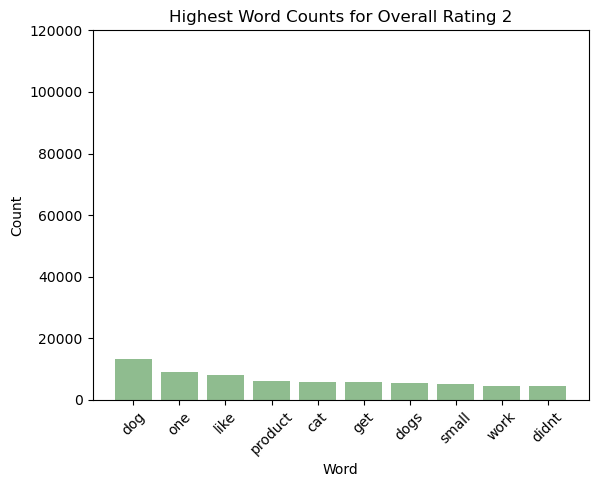

In [ ]:
overall_2 = df_exploded.filter(df_exploded.overall == 2.0) \
                        .groupBy("word").agg(sum("overall"), sum("count")) \
                        .sort("sum(count)", ascending=False)

avg_rating_2 = overall_2.withColumn("avg_rating", overall_2["sum(overall)"] / overall_2["sum(count)"]) \
                        .limit(10)

# plot histogram of word
overall_2 = avg_rating_2.toPandas()
fig, ax = plt.subplots()
ax.bar(overall_2['word'], 
        overall_2['sum(count)'], 
        color='darkseagreen')
ax.set_xlabel('Word')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=45)
# set y axis range to 30000
ax.set_ylim([0, 120000])
plt.title('Highest Word Counts for Overall Rating 2')
plt.show()

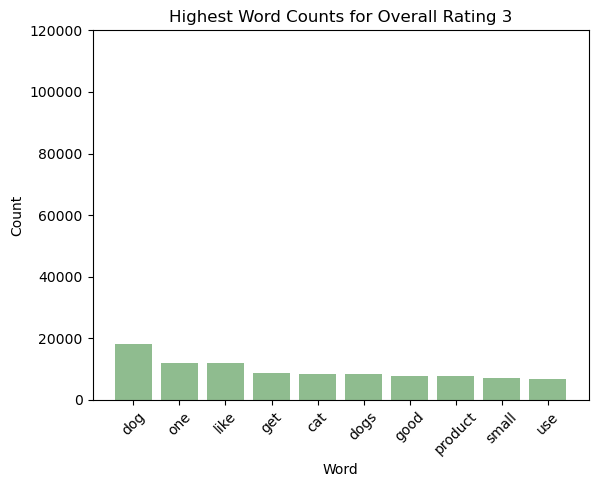

In [ ]:
overall_3 = df_exploded.filter(df_exploded.overall == 3.0) \
                        .groupBy("word").agg(sum("overall"), sum("count")) \
                        .sort("sum(count)", ascending=False)

avg_rating_3 = overall_3.withColumn("avg_rating", overall_3["sum(overall)"] / overall_3["sum(count)"]) \
                        .limit(10)

# plot histogram of word
overall_3 = avg_rating_3.toPandas()
fig, ax = plt.subplots()
ax.bar(overall_3['word'], 
        overall_3['sum(count)'], 
        color='darkseagreen')
ax.set_xlabel('Word')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=45)
# set y axis range to 30000
ax.set_ylim([0, 120000])
plt.title('Highest Word Counts for Overall Rating 3')
plt.show()

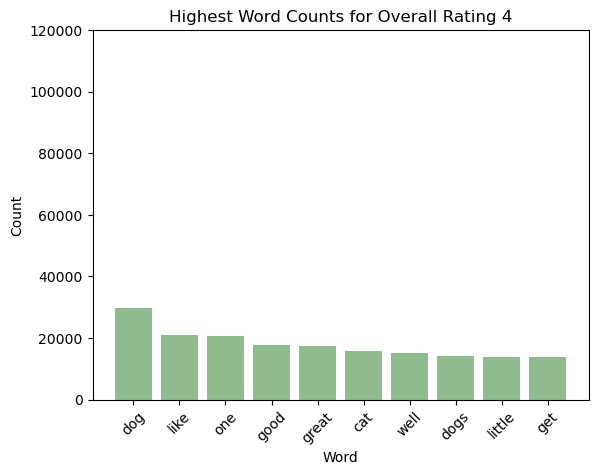

In [ ]:
overall_4 = df_exploded.filter(df_exploded.overall == 4.0) \
                        .groupBy("word").agg(sum("overall"), sum("count")) \
                        .sort("sum(count)", ascending=False)

avg_rating_4 = overall_4.withColumn("avg_rating", overall_4["sum(overall)"] / overall_4["sum(count)"]) \
                        .limit(10)

# plot histogram of word
overall_4 = avg_rating_4.toPandas()
fig, ax = plt.subplots()
ax.bar(overall_4['word'], 
        overall_4['sum(count)'], 
        color='darkseagreen')
ax.set_xlabel('Word')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=45)
# set y axis range to 30000
ax.set_ylim([0, 120000])
plt.title('Highest Word Counts for Overall Rating 4')
plt.show()

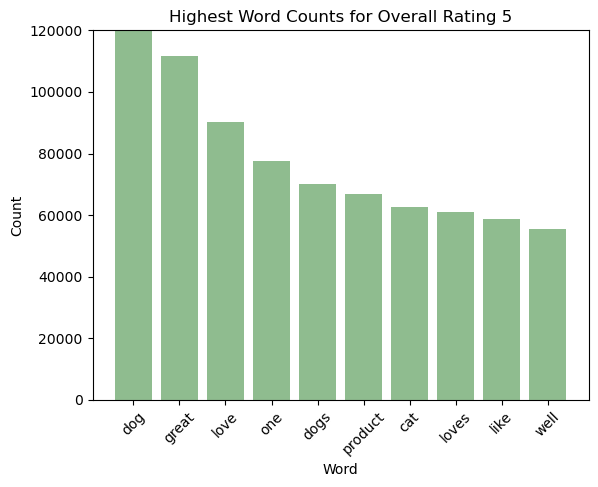

In [ ]:
overall_5 = df_exploded.filter(df_exploded.overall == 5.0) \
                        .groupBy("word").agg(sum("overall"), sum("count")) \
                        .sort("sum(count)", ascending=False)

avg_rating_5 = overall_5.withColumn("avg_rating", overall_5["sum(overall)"] / overall_5["sum(count)"]) \
                        .limit(10)

# plot histogram of word
overall_5 = avg_rating_5.toPandas()
fig, ax = plt.subplots()
ax.bar(overall_5['word'], 
        overall_5['sum(count)'], 
        color='darkseagreen')
ax.set_xlabel('Word')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=45)
# set y axis range to 30000
# ax.set_ylim([0, 120000])
plt.title('Highest Word Counts for Overall Rating 5')
plt.show()

# Metadata for Pet Supplies Products

In [ ]:
# # meta_data.printSchema()
# meta_schema = StructType([StructField("also_buy", ArrayType(StringType(), True), True),
#                             StructField("also_view", ArrayType(StringType(), True), True),
#                             StructField("asin", StringType(), True),
#                             StructField("brand", StringType(), True),
#                             StructField("category", ArrayType(StringType(), True), True),
#                             StructField("date", StringType(), True),
#                             StructField("description", ArrayType(StringType(), True), True),
#                             StructField("details", StructType([
#                                 StructField("\n    Item Weight: \n    ", StringType(), True),
#                                 StructField("\n    Package Dimensions: \n    ", StringType(), True),
#                                 StructField("\n    Product Dimensions: \n    ", StringType(), True),
#                                 StructField(" Date first listed on Amazon:", StringType(), True),
#                                 StructField(" UNSPSC Code:", StringType(), True),
#                                 StructField(" ASIN:", StringType(), True),
#                                 StructField(" ASIN: ", StringType(), True),
#                                 StructField(" Audio CD", StringType(), True),
#                                 StructField(" Audio Cassette", StringType(), True),
#                                 StructField(" Batteries", StringType(), True),
#                                 StructField(" Discontinued by manufacturer:", StringType(), True),
#                                 StructField(" Domestic Shipping: ", StringType(), True),
#                                 StructField(" Hardcover:", StringType(), True),
#                                 StructField(" International Shipping: ", StringType(), True),
#                                 StructField(" Item model number:", StringType(), True),
#                                 StructField(" Label:", StringType(), True),
#                                 StructField(" Language:", StringType(), True),
#                                 StructField(" Number of Discs:", StringType(), True),
#                                 StructField(" Publisher:", StringType(), True),
#                                 StructField(" Shipping Advisory:", StringType(), True),
#                                 StructField(" Shipping Weight:", StringType(), True),
#                                 StructField(" Subtitles:", StringType(), True),
#                                 StructField(" UPC:", StringType(), True),]), True),
#                             StructField("feature", ArrayType(StringType(), True), True),
#                             StructField("fit", StringType(), True),
#                             StructField("imageURL", ArrayType(StringType(), True), True),
#                             StructField("imageURLHighRes", ArrayType(StringType(), True), True),
#                             StructField("main_cat", StringType(), True),
#                             StructField("price", StringType(), True),
#                             StructField("rank", StringType(), True),
#                             StructField("similar_item", StringType(), True),
#                             StructField("tech1", StringType(), True),
#                             StructField("tech2", StringType(), True),
#                             StructField("title", StringType(), True)])

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Package Dimensions: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |--  Date first listed on Amazon:: string (nullable = true)
 |    |--  UNSPSC Code:: string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Audio CD: string (nullable = true)
 |    |-- Audio Cassette: string (nullable = true

In [28]:
meta_data = spark.read.json("data/meta_Pet_Supplies.json")

Check for null values

In [29]:
# check null values
print(f"Null asin: {meta_data.filter(sf.col('asin').isNull()).count()}")
print(f"Null also_buy: {meta_data.filter(sf.col('also_buy').isNull()).count()}")
print(f"Null also_view: {meta_data.filter(sf.col('also_view').isNull()).count()}")

Null asin: 0


Null also_buy: 0


Null also_view: 0


In [30]:
# select asin, also_buy, also_view from meta_df where also_view and also_buy are not null
#******************************
meta = meta_data.select('asin', 'also_buy', 'also_view')

In [31]:
# randomly sample 5000 rows from meta_data
meta = meta.sample(False, 0.5, seed=0) # df
print(f"Shape of meta: ({meta.count()}, {len(meta.columns)})") # (5,000, 3)

Shape of meta: (103038, 3)


In [32]:
# create rdd of view_data using the spark context and parallelize
view_rdd = sc.parallelize(meta.collect())

# print rows with count asin > 1 (duplicates)
dupes = view_rdd.map(lambda x: (x[0], 1)) \
                .reduceByKey(lambda x, y: x + y) \
                .filter(lambda x: x[1] > 1).collect()
# get only the asin
dupes = [x[0] for x in dupes]
print(dupes) # 6
# remove duplicate asin from view_rdd
view_rdd = view_rdd.filter(lambda x: x[0] not in dupes)
print(f"Shape of view_rdd after removing {len(dupes)} duplicate values: ({view_rdd.count()}, {len(view_rdd.take(1)[0])})") # (4,994, 3)

23/11/28 23:06:21 WARN TaskSetManager: Stage 61 contains a task of very large size (11506 KiB). The maximum recommended task size is 1000 KiB.
23/11/28 23:06:25 WARN TaskSetManager: Stage 63 contains a task of very large size (11506 KiB). The maximum recommended task size is 1000 KiB.


['B0000223WG', 'B00004YYEY', 'B00005MF9V', 'B000063JDV', 'B000067R6D', 'B00006H389', 'B00006JHRC', 'B00006JHRH', 'B00006OALX', 'B00006OAM1', 'B00007B406', 'B00008434F', 'B000084E2K', 'B000084DVX', 'B000084EAD', 'B000084DXG', 'B000084EBA', 'B000084EDB', 'B000084EFJ', 'B000084EB8', 'B000084EIZ', 'B000084EBE', 'B000084EG3', 'B000084EJO', 'B000084EKG', 'B000084EQB', 'B000084EVF', 'B000084EF6', 'B000084EBD', 'B000084EYQ', 'B000084DY1', 'B000084F5C', 'B000084EWW', 'B00008DF6D', 'B00008DF68', 'B00008DFAY', 'B00008DFPA', 'B00008DFNV', 'B00008DFOW', 'B00008DFPT', 'B00008DFOG', 'B00008MOIK', 'B00008Q2Y3', 'B000093HOV', 'B000093HIH', 'B00009LHMR', 'B00009NCZP', 'B00009ND76', 'B00009OLFA', 'B00009ZJ23', 'B0000AH3R4', 'B0000AH3QC', 'B0000B3AS5', 'B0000B3ASR', 'B0000B3BUU', 'B0000B3BV2', 'B0000B3BV0', 'B0000BYCM0', 'B0000BYDZD', 'B0000CEPED', 'B0000DAIPK', 'B0000DI7XC', 'B0000DI80R', 'B0000TSPY4', 'B0000TSPYE', 'B0000TSSC8', 'B0000TZ6U0', 'B0000UOE4I', 'B0000UOFJW', 'B0000UOFHO', 'B0000V828G', 'B000

23/11/28 23:06:32 WARN TaskSetManager: Stage 64 contains a task of very large size (11506 KiB). The maximum recommended task size is 1000 KiB.


Shape of view_rdd after removing 1911 duplicate values: (99216, 3)


In [33]:
# check amount of unique asin
print(f"Count unique asin: {view_rdd.map(lambda x: x[0]).distinct().count()}")

23/11/28 23:07:01 WARN TaskSetManager: Stage 65 contains a task of very large size (11506 KiB). The maximum recommended task size is 1000 KiB.


Count unique asin: 99216


### Joining Product Metadata and Review Data

In [34]:
joined_df = data_df.select('asin', 'reviewerID') \
                    .join(meta.select('asin', 'also_buy', 'also_view'),on='asin', how='inner') \
                    .filter(sf.col('reviewerID').isNotNull())

In [35]:
# count distinct also_buy and asin -> check if also_buy corresponds exactly to asin
print(f"Count distinct also_buy: {joined_df.select('also_buy').distinct().count()}")
print(f"Count distinct asin: {joined_df.select('asin').distinct().count()}")

Count distinct also_buy: 17628


Count distinct asin: 101124


In [14]:
# select 2000 rows from joined_df
# sample_joined = joined_df.sample(False, 0.05, seed=0)

## What percent of similar purchased items are purchased?
## What percent of viewed items are purchased?

In [64]:
# find where also_buy and also_view are not empty
filter_buy = joined_df.filter(sf.size(sf.col('also_buy')) > 0) \
                        .filter(sf.size(sf.col('also_view')) > 0)
# sample 2000 rows from combined_df
sample_combined = filter_buy.sample(False, 0.005, seed=0)

Create lists of what each reviewer bought and viewed
 1. group by reviewerID
 2. create list of all asin with that reviewerID

In [65]:
# group by reviewerID and create new column with list of asin
grouped_reviewer = filter_buy.groupBy('reviewerID') \
                        .agg(sf.collect_list('asin').alias('reviewer_bought'))
grouped_reviewer = filter_buy.join(grouped_reviewer, on='reviewerID', how='outer').select('reviewerID', 'asin', 'reviewer_bought', 'also_buy', 'also_view')
grouped_reviewer.show()

+--------------------+----------+--------------------+--------------------+--------------------+
|          reviewerID|      asin|     reviewer_bought|            also_buy|           also_view|
+--------------------+----------+--------------------+--------------------+--------------------+
|A0020320YVA26ZNLOUX3|B0009YYSBE|[B01DMTPS8E, B000...|[B004ZM65LC, B000...|[B000HCI5CG, B01B...|
|A0020320YVA26ZNLOUX3|B01DMTPS8E|[B01DMTPS8E, B000...|[B01M4OPTQD, B071...|[B007P54O0A, B00F...|
|A0035644GWEG3A8V1G74|B0002ASCGM|[B0002ASCGM, B000...|[B000HHQGWW, B01N...|[B001LUL4L2, B003...|
|A0035644GWEG3A8V1G74|B0002ASCGM|[B0002ASCGM, B000...|[B000HHQGWW, B01N...|[B001LUL4L2, B003...|
|A0037056181PEYWBHCUZ|B00ZK1IBN2|        [B00ZK1IBN2]|[B01INNOJIY, B004...|[B003RQVGKC, B004...|
|A0084055RM28SR8A0DQM|B004ZM7JB2|        [B004ZM7JB2]|[B003JHLY1U, B004...|[B00ODRO7W8, B00F...|
|A0214039WA4BHU747SQ4|B00YS5QFLG|        [B00YS5QFLG]|[B01EFMRPGA, B01E...|[B017UAJBUM, B00X...|
|A0231053UDFCC75M0RI3|B00VE78Z

In [ ]:
# sample group_reviewer
# sample_grouped_reviewer = grouped_reviewer.sample(False, 0.005, seed=0)
# # combine also_buy and also_view into their own columns for that reviewerID
# combined_df = sample_grouped_reviewer.agg(sf.flatten(sf.collect_list("also_buy")),
#                                                 sf.flatten(sf.collect_list("also_view")))
# combined_df.show()

In [68]:
# calculating how many items in also_buy are in also_view (intersection)
buy_also_bought = grouped_reviewer.withColumn("intersect_bought_count", sf.size(sf.array_intersect("also_buy", "reviewer_bought"))) \
                                        .sort(sf.desc("intersect_bought_count"))
buy_also_bought.show()

+--------------+----------+--------------------+--------------------+--------------------+----------------------+
|    reviewerID|      asin|     reviewer_bought|            also_buy|           also_view|intersect_bought_count|
+--------------+----------+--------------------+--------------------+--------------------+----------------------+
|A24G85HUDLJ8JA|B004INIUQQ|[B0009YUIZE, B002...|[B002CJG13C, B002...|[B002CJG1TG, B002...|                     5|
|A3V0D97QKXDN5R|B00283LQI2|[B000WTEJC4, B000...|[B078SL91Q9, B077...|[B0777NRJ2N, B002...|                     5|
|A24G85HUDLJ8JA|B002CJAOOO|[B0009YUIZE, B002...|[B0085JN38E, B001...|[B077Y6GNT2, B002...|                     5|
|A24G85HUDLJ8JA|B002CJCEQA|[B0009YUIZE, B002...|[B002CJG1HI, B001...|[B002CJARSW, B001...|                     5|
|A24G85HUDLJ8JA|B002CJCEQA|[B0009YUIZE, B002...|[B002CJG1HI, B001...|[B002CJARSW, B001...|                     5|
|A29GWIJL72GXXZ|B0002DJXJE|[B00006IX5A, B000...|[B00ZE65PEG, B000...|[B000YKD5QW, B000..

In [70]:
buy_viewed = buy_also_bought.withColumn("intersect_view_count", sf.size(sf.array_intersect("also_view", "reviewer_bought"))) \
                                        .sort(sf.desc("intersect_view_count"))
buy_viewed.show()

+--------------+----------+--------------------+--------------------+--------------------+----------------------+--------------------+
|    reviewerID|      asin|     reviewer_bought|            also_buy|           also_view|intersect_bought_count|intersect_view_count|
+--------------+----------+--------------------+--------------------+--------------------+----------------------+--------------------+
|A3GFJ2GBY6779L|B000UJREH8|[B0002AR15U, B000...|[B0002DHNY6, B000...|[B009MKCI2W, B000...|                     3|                   4|
|A29GWIJL72GXXZ|B000MCXXZU|[B00006IX5A, B000...|[B0039T5MEI, B000...|[B0039T5MEI, B003...|                     3|                   4|
| AOTJ1TVF87U4L|B000UJREH8|[B0002AR17S, B000...|[B0002DHNY6, B000...|[B009MKCI2W, B000...|                     3|                   4|
|A29GWIJL72GXXZ|B000MCXXZU|[B00006IX5A, B000...|[B0039T5MEI, B000...|[B0039T5MEI, B003...|                     3|                   4|
|A3V0D97QKXDN5R|B002CJCEQA|[B000WTEJC4, B000...|[B002CJ

In [74]:
# calculate percentages of bought items that are actually bought, and viewed items that are actually bought
prob_buy = buy_viewed.withColumn("percent_buy", sf.round(sf.col("intersect_bought_count") / sf.size(sf.col("reviewer_bought")) * 100,2)) \
                        .withColumn("percent_view", sf.round(sf.col("intersect_view_count") / sf.size(sf.col("reviewer_bought")) * 100,2))

prob_buy.show()

+--------------+----------+--------------------+--------------------+--------------------+----------------------+--------------------+-----------+------------+
|    reviewerID|      asin|     reviewer_bought|            also_buy|           also_view|intersect_bought_count|intersect_view_count|percent_buy|percent_view|
+--------------+----------+--------------------+--------------------+--------------------+----------------------+--------------------+-----------+------------+
|A3GFJ2GBY6779L|B000UJREH8|[B0002AR15U, B000...|[B0002DHNY6, B000...|[B009MKCI2W, B000...|                     3|                   4|      21.43|       28.57|
|A29GWIJL72GXXZ|B000MCXXZU|[B00006IX5A, B000...|[B0039T5MEI, B000...|[B0039T5MEI, B003...|                     3|                   4|      15.79|       21.05|
| AOTJ1TVF87U4L|B000UJREH8|[B0002AR17S, B000...|[B0002DHNY6, B000...|[B009MKCI2W, B000...|                     3|                   4|      13.04|       17.39|
|A29GWIJL72GXXZ|B000MCXXZU|[B00006IX5A, 

23/11/29 00:19:12 WARN HeartbeatReceiver: Removing executor 3 with no recent heartbeats: 897544 ms exceeds timeout 120000 ms
23/11/29 00:19:12 ERROR TaskSchedulerImpl: Lost executor 3 on 192.168.0.39: Executor heartbeat timed out after 897544 ms


graph

In [26]:
# graph = nx.DiGraph()

# Add nodes (products)
# for product in graph_data:
#     graph.add_node(product)

# Add edges (relationships)
# for product, also_buy_list in graph_data.items():
#     for also_buy in also_buy_list:
#         graph.add_edge(product, also_buy)

In [50]:
# Draw the graph
# pos = nx.spring_layout(graph)
# nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)
# plt.show()